# 基于Spark的中文分词实现

# <环境配置>

**1.Spark: spark-1.5.1-bin-hadoop2.4**
****
**2.Python：Python3.5**

In [14]:
# -*- coding=utf8 -*-
"""
从句子中提取汉字字符，暂时不考虑数字和英文字母
"""
import re
characterPartern = re.compile(u"[\u4E00-\u9FD5]+", re.U)
#将单个词语的长度限制为4（Words_MAX_LENGTH）
Words_Max_Length = 4
def  FindCharacter(sentence):
    """返回汉字"""
    return characterPartern.findall(sentence)

In [15]:
def TextSegment(sentence):
    """将文本切分成词语列表"""
    wordSets = {}
    sentenceLength = len(sentence)
    for i in range(len(sentence)):
        for j in range(1, min(sentenceLength - i, Words_Max_Length + 1)):
            word = sentence[i: j + i]
            wordSets[word] = wordSets.get(word, 0) + 1
    return wordSets.items()

In [16]:
from __future__ import division
from math import log
from pyspark import SparkContext, SparkConf

In [17]:
import os
os.environ["SPARK_HOME"] = "D:\Spark\spark-1.5.1-bin-hadoop2.4"

In [18]:
def init_spark_context():
    """初始化spark环境"""
    sc = SparkContext(appName="PythonWordCount")
    return sc

# PhraseInfo类

**PhraseInfo类通过计算每个汉字组合的信息熵，利用熵来构建分词功能，将文本中熵比较小的汉字组合排除。**
***
**calc_entropy 计算每个汉字组合的信息熵**
***
**calc_is_keep_right，针对一个短语中的每个汉字，是否保留其右边的汉字**
***
**calc_is_keep_left，针对一个短语中的每个汉字，是否保留其左边的汉字**
***
**calc_is_keep，是否保留当前汉字**

In [19]:
class PhraseInfo(object):
    """词频信息"""
    def __init__(self, frequency):
        self.frequency = frequency
        self.left_trim = {}
        self.right_trim = {}

    @staticmethod
    def calc_entropy(trim):
        """计算熵"""
        if not trim:
            return float('-inf')

        trim_sum = sum(trim.values())
        entropy = 0.0
        for _, value in trim.items():
            p = value / trim_sum
            entropy -= p * log(p)
        return entropy

    def calc_is_keep_right(self):
        right_entropy = self.calc_entropy(self.right_trim)
        if right_entropy < 1.0:
            return False
        return True

    def calc_is_keep_left(self):
        left_entropy = self.calc_entropy(self.left_trim)
        if left_entropy < 1.0:
            return False
        return True

    def calc_is_keep(self):
        if self.calc_is_keep_left() and self.calc_is_keep_right():
            return True
        return False

In [20]:
class SplitterEngine(object):
    """分词引擎"""
    def __init__(self, spark_context, corpus):
        self.sc = spark_context
        self.corpus_path = corpus

        self.result_phrase_set = None
        self.phrase_dict_map = None
        self.final_result = {}

    def split(self):
        """利用spark对文本进行分词，过滤掉出现频率比较低的词组合"""
        rawRDD = self.sc.textFile(self.corpus_path)
        characterRDD = rawRDD.flatMap(lambda line: FindCharacter(line))

        raw_phraseRDD = characterRDD.flatMap(lambda sentence: TextSegment(sentence))

        phraseRDD = raw_phraseRDD.reduceByKey(lambda x, y: x + y)
        phrase_dict_map = dict(phraseRDD.collect())
        total_count = 0
        for _, freq in phrase_dict_map.items():
            total_count += freq

        def _filter(pair):
            phrase, frequency = pair
            max_ff = 0
            for i in range(1, len(phrase)):
                left = phrase[:i]
                right = phrase[i:]
                left_f = phrase_dict_map.get(left, 0)
                right_f = phrase_dict_map.get(right, 0)
                max_ff = max(left_f * right_f, max_ff)
            return total_count * frequency / max_ff > 100.0

        target_phraseRDD = phraseRDD.filter(lambda x: len(x[0]) >= 2 and x[1] >= 3)
        result_phraseRDD = target_phraseRDD.filter(lambda x: _filter(x))
        self.result_phrase_set = set(result_phraseRDD.keys().collect())
        self.phrase_dict_map = {key: PhraseInfo(val) for key, val in phrase_dict_map.items()}

    def FilterWords(self):
        """根据熵过滤掉出现熵较低的汉字组合"""
        for phrase, phrase_info in self.phrase_dict_map.items():
            """分别计算汉字个数大于3个的词语中 左、右半部分在文本中的出现频数"""
            if len(phrase) < 3:
                continue
            freq = phrase_info.frequency

            left_trim = phrase[:1]
            right_part = phrase[1:]
            if right_part in self.result_phrase_set\
                    and right_part in self.phrase_dict_map:
                p_info = self.phrase_dict_map[right_part]
                p_info.left_trim[left_trim] = p_info.left_trim.get(left_trim, 0) + freq

            right_trim = phrase[-1:]
            left_part = phrase[:-1]
            if left_part in self.result_phrase_set \
                    and left_part in self.phrase_dict_map:
                p_info = self.phrase_dict_map[left_part]
                p_info.right_trim[right_trim] = p_info.right_trim.get(right_trim, 0) + freq

        for words in self.result_phrase_set:
            if words not in self.phrase_dict_map:
                continue

            words_info = self.phrase_dict_map[words]
            if words_info.calc_is_keep():
                self.final_result[words] = words_info.frequency

    def ShowOutput(self):
        """显示计算结果"""
        for phrase, frequency in self.final_result.items():
            print(phrase, frequency)

In [21]:
spark_content = init_spark_context()

**本文文件取自金庸武侠小说《射雕英雄传》**

In [22]:
corpus_path = 'D:\Spark\spark-1.5.1-bin-hadoop2.4\examples\src\main\python\shediao.txt'

In [23]:
engine = SplitterEngine(spark_content, corpus_path)

In [24]:
engine.split()

In [25]:
engine.FilterWords()

In [26]:
engine.ShowOutput()

豪迈 5
吃饭 8
衣衫 20
义弟 21
决不致 9
瘟疫 4
带队向 3
去盗 11
江湖上 60
又惊又 85
兀自 54
匆忙 4
奔腾 6
蓦地里 16
清脆 9
石壁上 4
及不上 7
伸手扶 10
个小小 13
倘若 49
府里 10
蒙古包 15
劲风 17
阁下 9
亲兵 60
铁扇 10
位前辈 10
焦木 58
傻姑 168
乌云 15
文字 10
位师兄 5
光照在 5
早已 163
刷刷 20
步向前 4
兵齐声 8
有三四 5
细细 33
驸马爷 4
条羊腿 3
帐篷 4
奔跑 17
掌力震 9
楼梯 14
威猛 8
兵刃 46
列成 6
西征 16
喜爱 9
腰间 47
译成 5
尚未 72
体内 7
烛火 10
故事 15
求大汗 6
受辱 3
三十六 12
少庄主 8
尖刺 8
大缆 8
逃脱 6
稳稳 21
金环 10
陆冠英 230
交给 34
烧成 6
临敌 9
胡涂 22
狗王 14
第三次 7
因此 79
西毒 85
全真 316
遇到 52
之类 6
鸟儿 4
亲卫 9
爱玩 4
丐帮 161
部族中 4
尴尬 6
破烂 8
这家伙 12
掌柜 10
并排 5
忍住 11
瞧不起 9
进洞 17
竟尔 16
并未 52
单刀 26
沙通天 125
步走 36
快活 6
弓箭 10
俘虏 9
华山 64
毒辣 4
榻上 4
根树 7
滩上 11
塞入 6
途中 14
陆庄主 109
接着 71
母亲 108
背脊 10
秤杆 10
舒畅 3
征战 4
个相貌 5
皇帝 72
屠牛 3
攻近 3
神态 24
反过来 6
安静 11
臭虫 9
拉扯 6
题目 8
马道长 12
不必多 9
教训 14
满腔 17
小溪 5
四弟子 14
追踪 7
临安 84
一步退 3
要试试 3
指点 59
指尖 14
老人家 76
铁枪庙 9
共有 25
乍见 6
局面 8
妹子 25
固然 40
闪闪 17
对准了 13
运劲 33
金狗 9
从西域 5
奋力 32
想法子 6
和尚 50
精妙 14
热气 11
舌头 12
巡逻的 3
轰隆 7
日一早 5
松枝 3
蹄声 23
下三路 4
喊声 22
之极的 17
周师兄 17
转头 83
越来越 48
插了五 3
再和她 3
集于 6
群蛇 11
女孩儿 15
这幅画 7
扒了 3


In [27]:
dicts = engine.final_result

**对文本分词的结果进行排序**

In [28]:
from operator import itemgetter
swd = sorted(dicts.items(), key=itemgetter(1), reverse=True)
swd = swd[1:50]

In [29]:
ss = tuple(swd)

In [30]:
ss

(('黄蓉', 3268),
 ('欧阳锋', 998),
 ('洪七公', 926),
 ('自己', 853),
 ('甚么', 807),
 ('黄药师', 759),
 ('咱们', 636),
 ('师父', 599),
 ('周伯通', 557),
 ('武功', 543),
 ('听得', 534),
 ('欧阳克', 521),
 ('丘处机', 512),
 ('当下', 472),
 ('知道', 460),
 ('梅超风', 417),
 ('原来', 402),
 ('柯镇恶', 370),
 ('蒙古', 370),
 ('杨康', 368),
 ('怎么', 367),
 ('爹爹', 352),
 ('裘千仞', 342),
 ('突然', 329),
 ('左手', 326),
 ('眼见', 325),
 ('全真', 316),
 ('朱聪', 316),
 ('铁木真', 313),
 ('众人', 305),
 ('不禁', 298),
 ('忽然', 297),
 ('如此', 296),
 ('功夫', 295),
 ('虽然', 293),
 ('双手', 292),
 ('江南', 281),
 ('如何', 278),
 ('穆念慈', 275),
 ('右手', 269),
 ('完颜康', 269),
 ('哪里', 261),
 ('兄弟', 257),
 ('弟子', 254),
 ('伸手', 249),
 ('桃花岛', 239),
 ('脸上', 237),
 ('今日', 235),
 ('陆冠英', 230))

# 生成词云

In [39]:
from os import path
from wordcloud import WordCloud

In [40]:
wordcloud = WordCloud().fit_words(ss)

(-0.5, 399.5, 199.5, -0.5)

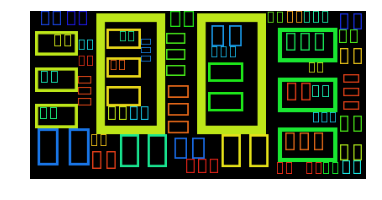

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

In [42]:
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).fit_words(ss)

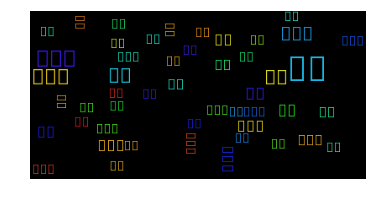

In [43]:
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 简单英文版本分词

In [1]:
from __future__ import print_function
import sys
from operator import add
from pyspark import SparkContext

In [2]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
import os
import pyspark
os.environ["SPARK_HOME"] = "D:\Spark\spark-1.5.1-bin-hadoop2.4"

In [4]:
sc = SparkContext(appName="PythonWordCount")

In [5]:
lines = sc.textFile('D:\Spark\spark-1.5.1-bin-hadoop2.4\examples\src\main\python\wordcount.py', 1)

In [6]:
counts = lines.flatMap(lambda x: x.split(' ')).map(lambda x: (x, 1)).reduceByKey(add)
output = counts.collect()    

In [7]:
for (word, count) in output:
        print("%s: %i" % (word, count))

: 99
sc: 1
NOTICE: 1
copy: 1
additional: 1
applicable: 1
governing: 1
for: 3
(the: 1
agreed: 1
with: 2
limitations: 1
(ASF): 1
License.: 2
either: 1
import: 4
add: 1
len(sys.argv): 1
"License");: 1
(word,: 2
Software: 1
.reduceByKey(add): 1
You: 2
law: 1
agreements.: 1
at: 1
sc.stop(): 1
you: 1
required: 1
print("Usage:: 1
exit(-1): 1
counts.collect(): 1
2:: 1
and: 1
The: 1
license: 1
by: 1
sys: 1
x.split(': 1
express: 1
a: 1
language: 1
lines.flatMap(lambda: 1
BASIS,: 1
contributor: 1
in: 3
permissions: 1
print("%s:: 1
See: 2
may: 2
2.0: 1
x:: 2
work: 1
wordcount: 1
licenses: 1
==: 1
CONDITIONS: 1
lines: 1
copyright: 1
OF: 1
License: 3
counts: 1
if: 2
__name__: 1
file: 3
(x,: 1
.map(lambda: 1
from: 3
the: 9
WARRANTIES: 1
=: 4
#: 16
SparkContext(appName="PythonWordCount"): 1
KIND,: 1
to: 3
obtain: 1
Unless: 1
%i": 1
1)): 1
WITHOUT: 1
IS": 1
ASF: 1
__future__: 1
of: 1
Foundation: 1
one: 1
Licensed: 1
this: 3
information: 1
operator: 1
print_function: 1
under: 4
not: 1
more: 1
software: 

In [8]:
sc.stop()